In [16]:
import sys
import rosbag
import time
import rospy
import os
import argparse
import math
import re
import h5py
import numpy as np
import ros_numpy
import matplotlib.pyplot as plt
from sensor_msgs.msg import Image, PointCloud2, PointField, JointState
from cv_bridge import CvBridge, CvBridgeError
from tqdm import tqdm, trange

## user define
- frame rate
- chunck length
- bags directory
- output file path/name
- topics need to transfer
- reference
    - https://support.hdfgroup.org/HDF5/doc/Advanced/Chunking/
    - http://docs.h5py.org/en/stable/high/dataset.html

In [17]:
frame_rate = 30  # Hz
chunck_len = 100  # number of frames in .hdf5 file
#bags_dir = '/home/richtong/bag-extract-hdf5/bag'
bags_dir = '/home/argsubt/0804hdf5/bag/'
#output_file_prefix = '/home/richtong/bag-extract-hdf5/out'
output_file_prefix = '/home/argsubt/0804hdf5/out/'

topic_list = {
    #'/husky2/velodyne1/velodyne_points': 'lidar',
    #'/husky2/camera_left/color/image_raw': 'left_image',
    #'/husky2/camera_middle/color/image_raw': 'middle_image',
    #'/husky2/camera_right/color/image_raw': 'right_image',
    #'/husky2/camera_left/aligned_depth_to_color/image_raw': 'left_depth',
    #'/husky2/camera_middle/aligned_depth_to_color/image_raw': 'middle_depth',
    #'/husky2/camera_right/aligned_depth_to_color/image_raw': 'right_depth',
    #'/wx200/joint_states': 'robot_arm',
    '/camera/aligned_depth_to_color/image_raw':'depth_img',
    '/camera/color/image_raw':'img'
}

#info for meta
vehicle = 'locobot'
place = 'ED-B1'
date_time = '07/21-19:58'

## user define 
msg to numpy array

ros_numpy : https://github.com/eric-wieser/ros_numpy

- image (width,height,channel)
- point cloud (xyz, number_of_points)

In [18]:
def msg_to_np(topic,msg):
    data = None
    if topic == '/husky2/velodyne1/velodyne_points':
        data_tmp = ros_numpy.point_cloud2.pointcloud2_to_xyz_array(
            msg)
        # swapaxis (3,points_number)
        data_tmp = np.swapaxes(data_tmp, 1, 0)
        data = []
        for i in range(data_tmp.shape[0]):
            data.append(np.array(data_tmp[i]))

    elif topic == '/husky2/camera_left/color/image_raw':
        data = ros_numpy.image.image_to_numpy(msg)

    elif topic == '/husky2/camera_middle/color/image_raw':
        data = ros_numpy.image.image_to_numpy(msg)

    elif topic == '/husky2/camera_right/color/image_raw':
        data = ros_numpy.image.image_to_numpy(msg)

    elif topic == '/husky2/camera_left/aligned_depth_to_color/image_raw':
        data = ros_numpy.image.image_to_numpy(msg)

    elif topic == '/husky2/camera_middle/aligned_depth_to_color/image_raw':
        data = ros_numpy.image.image_to_numpy(msg)

    elif topic == '/husky2/camera_right/aligned_depth_to_color/image_raw':
        data = ros_numpy.image.image_to_numpy(msg)
    elif topic == '/wx200/joint_states':
        cur_pos_arr = np.zeros( (8, 1) )
        data = np.zeros( (8, 1) )
        for i in range(0, len(msg.position)):
            cur_pos_arr[i, 0] = msg.position[i]
            print(cur_pos_arr[i, 0])
        data = np.append(data, cur_pos_arr, axis = 1)
    elif topic == '/camera/color/image_raw':
        data = ros_numpy.image.image_to_numpy(msg)
    elif topic == '/camera/aligned_depth_to_color/image_raw':
        data = ros_numpy.image.image_to_numpy(msg)
    
    return data

## add dataset
    lidar has unknown length data
    need to use special_dtype

In [19]:
def add_dataset(f, key, data, chunck_len):
    if key == 'lidar':
        dt = h5py.special_dtype(vlen=np.dtype('float32'))
        shape = (chunck_len, 3)
        max_shape = (None, 3)
    else:
        dt = data.dtype
        shape = (chunck_len,) + data.shape
        max_shape = (None,) + data.shape

    return f.create_dataset(key, shape=shape,
                        maxshape=max_shape, dtype=dt, chunks=True)

In [20]:
def add_meta(f):
    meta = f.create_group('metadata')
    meta.attrs['vehicle'] = vehicle
    meta.attrs['place'] = 'ED-B1'
    meta.attrs['date_time'] = date_time
    meta.attrs['frame_rate'] = frame_rate
    meta.attrs['trajectory_length'] = chunck_len
    for i,(key,value) in enumerate(topic_list.items()):
        meta.attrs[value] = key

## start process bags
rosbag : http://wiki.ros.org/rosbag/Code%20API

In [21]:
bags = os.listdir(bags_dir)[::-1]
bags.sort()
b = None
frame = 0
step = 0
epi = 0
tp = None
dropped_frame = 0
mark, report = {}, {}
for value in topic_list.values():
    mark.update({value:0})
    report.update({value:[]})

f = h5py.File(output_file_prefix+"_%03d.hdf5"%epi, 'w')
add_meta(f)

pbar = tqdm(bags)

for bag_name in pbar:
    print(bag_name)
    b = rosbag.Bag(bags_dir+'/'+bag_name)
    for topic, msg, t in b.read_messages(topic_list.keys()):
        if tp is None:
            tp = t
        else:
            if not topic_list[topic] in f.keys():
                # create dataset
                data = msg_to_np(topic,msg)
                dset = add_dataset(f,topic_list[topic],data,chunck_len)

            f[topic_list[topic]][step] = msg_to_np(topic,msg)
            mark[topic_list[topic]] = 1
            
            # cut frame ------------------------------------------------------------------
            if (t-tp).to_sec() > 1./frame_rate:
                tp = t
                drop = False
                frame += 1
                # if there is one msg missing in this frame
                # drop this frame
                for i, (key, value) in enumerate(mark.items()):
                    report[key].append(value)
                    if value is 0:
                        drop = True
                        dropped_frame += 1
                    mark[key] = 0

                pbar.set_description("frame:%d, drop:%d , bag:%s"%(frame,dropped_frame,bag_name))
                if not drop:
                    step += 1
                    if step == chunck_len:
                        step = 0
                        epi += 1
                        f.close()
                        del f
                        f = h5py.File(output_file_prefix+"_%03d.hdf5"%epi, 'w')
                        add_meta(f)
                    # end if
               # end if
            # end if
        # end if
    # end for
    b.close()
    del b
f.close()
print 'finish'

frame:8, drop:0 , bag:hcc_lab9.bag:   0%|          | 0/1 [00:00<?, ?it/s]

hcc_lab9.bag


frame:274, drop:0 , bag:hcc_lab9.bag: 100%|██████████| 1/1 [00:04<00:00,  4.83s/it]


finish


## status report
    show the dropped frame numbers

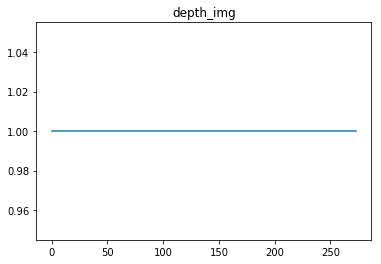

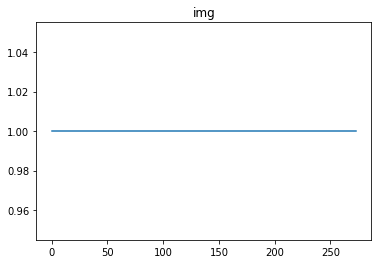

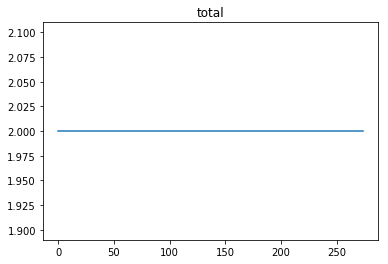

In [22]:
stat = []
for i, (key, value) in enumerate(report.items()):
    stat.append(value)
    plt.title(key)
    plt.plot(value)
    plt.show()
total = np.sum(stat,axis=0)
plt.title('total')
plt.plot(total)
plt.show()